1. Реализовать формулу подсчета длительности теста, сравнить ее с онлайн калькуляторами (например https://mindbox.ru/tools/ab-test-calculator/ ). При сравнении оценить мощность критерия при указанном изменении и рассчитанном количестве наблюдений в выборке. 


In [27]:
import scipy.stats as sps
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go

In [28]:
def get_power(p_value, alpha=0.05):
    p_value = np.array(p_value)
    cr_pow = p_value[p_value < alpha].shape[0] / p_value.shape[0] * 100
    print()
    return cr_pow
    
    
def qq_plot(vals):
    probs = []
    p_vals = np.array(vals)
    x = [0.01 * i for i in range(1, 101)]
    for i in range(1, 101):
        step = 0.01 * i
        probs.append(p_vals[p_vals < step].shape[0] / p_vals.shape[0])
    plt.figure(figsize=(4, 3))
    plt.scatter(x, np.array(probs))
    plt.plot(x, x, c='r')
    plt.show()


In [29]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1-alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1**2+sigma_2**2/k) / (delta_effect **2)
    return np.ceil(n)
# необходимое количество наблюдений
# k - количество вариантов, которые участвуют в А/Б тесте.
# delta_effect - разница ожидаемого эффекта между двумя вариантами.
# sigma_1 - стандартное отклонение первого варианта.
# sigma_2 - стандартное отклонение второго варианта.
# alpha - уровень значимости (ошибка первого рода).
# beta - мощность теста (вероятность обнаружить разницу в эффекте, если она действительно есть) (у нас мощность 80)

# dur = duration(k=1,delta_effect=5, sigma_1=0.5, sigma_2=0.5)
# print("Продолжительность теста:", dur)
# чем больше эффект тем быстрее получаем результаты

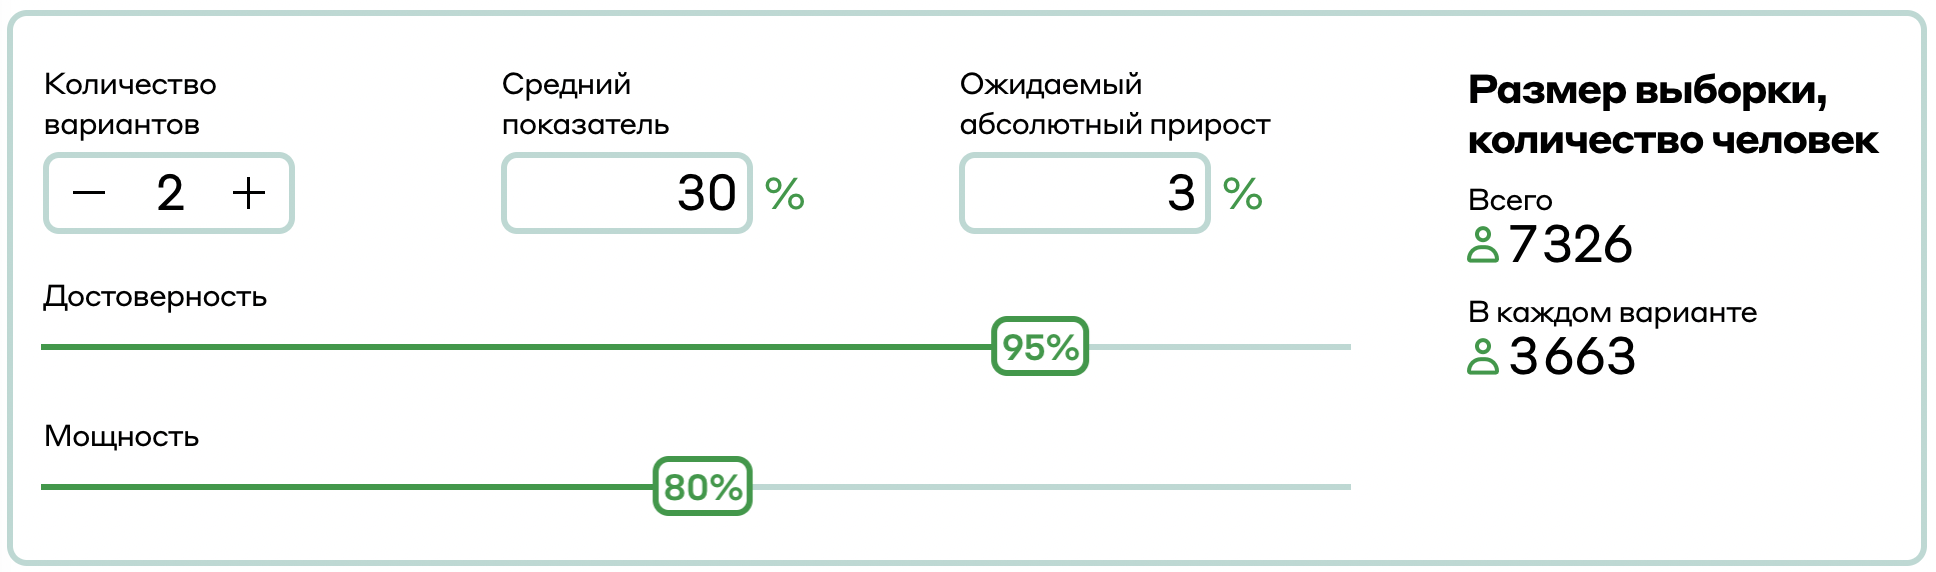

In [30]:
f=lambda p: np.sqrt(p*(1-p))

dur = duration(k=1, delta_effect=0.03, sigma_1=f(.3), sigma_2=f(.3), alpha=0.05, beta = 0.2)
print("Продолжительность теста:", dur)


Продолжительность теста: 7326.0


*продолжительности тестов совпали*

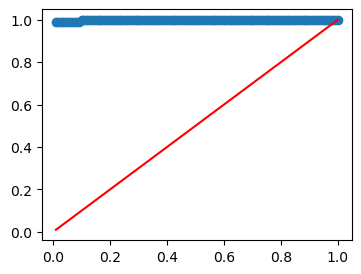


Мощность критерия: 99.0


In [31]:
dur = int(dur)
# размер выборки для контрольной группы
size_c =  dur // 2 
# размер выборки для тестовой группы
size_t = dur // 2
# количество экспериментов
n_exp = 100
# ожидаемый эффект (разница между средними значениями выборок)
effect = 0.05
# уровень значимости
alpha =0.05
# вероятность ошибки второго рода
beta =0.2
p_values = []
for _ in range(n_exp):
    a_control = sps.bernoulli.rvs(p=0.3, size=size_c)
    b_test = sps.bernoulli.rvs(p=0.3+ effect, size = size_t)
    p_values.append(sps.ttest_ind(a_control, b_test, equal_var=True).pvalue)

    

qq_plot(p_values)
print(f"Мощность критерия: {get_power(p_values)}")


*мощность большая - говорит о том, что рассчитанный объем выборки действительно позволяет оценить полученный эффект*

2. Реализовать метод линеаризации. Проверить для него корректность и мощность. Мощность должна быть больше, чем просто на обычных значениях конверсии пользователей.


Мощность критерия: 4.9


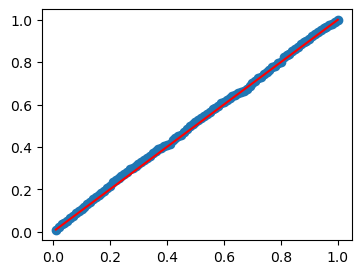


Мощность линеаризованного критерия: 5.800000000000001


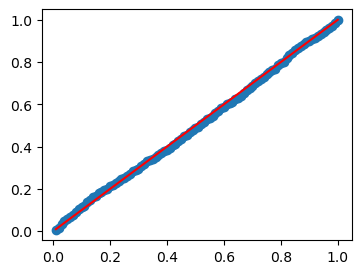

In [39]:
# оценивается число кликов на фоне числа показов у пользователя
# В линеаризации реализована линейная регрессия между количеством кликов и количеством просмотров для контрольной группы. 
# Это позволяет получить корректировку для конверсии, которая учитывает влияние количества просмотров на количество кликов. 
# x= sps.expon.rvs(loc=100, scale=100, size=1000)
n_exp = 1000
n_values = []
n_values_lin = []
for _ in range(n_exp):
    records = []
    for i in range(100):
        n_views = int(sps.expon.rvs(loc=100, scale=140))
        clicks = sps.bernoulli.rvs(p=0.05, size=n_views)
        records.append([n_views, np.sum(clicks), np.sum(clicks)/n_views, "A"])
    for i in range(100):
        n_views = int(sps.expon.rvs(loc=100 + effect, scale=140))
        clicks = sps.bernoulli.rvs(p=0.05, size=n_views)
        records.append([n_views, np.sum(clicks), np.sum(clicks)/n_views, "B"])
    df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])
    
    cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]['views'].sum()
    df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]
    x_a = df_data[df_data["group"] == "A"]["cr"]
    x_b = df_data[df_data["group"] == "B"]["cr"]
    p_value = sps.ttest_ind(x_a, x_b).pvalue
    n_values.append(p_value)
    x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
    x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
    p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
    n_values_lin.append(p_value_lin)
# сгенерировали выборки данных для контрольной и тестовой групп, содержащие данные о количестве просмотров страницы, количестве кликов и конверсии для каждого пользователя. 
# рассчитаем линейную регрессию между количеством кликов и количеством просмотров для контрольной группы, чтобы получить корректировку для конверсии. 

# проведем t-тест для оценки статистической значимости различия конверсии между контрольной и тестовой группами, как с использованием корректировки, так и без нее. 
# Результаты t-теста записываются в списки p_value_c и p_value_t для контрольной и тестовой групп соответственно. 
print(f"Мощность критерия: {get_power(n_values)}")
qq_plot(n_values)
print(f"Мощность линеаризованного критерия: {get_power(n_values_lin)}")
qq_plot(n_values_lin)

Да, у линеаризованного критерия мощность выше

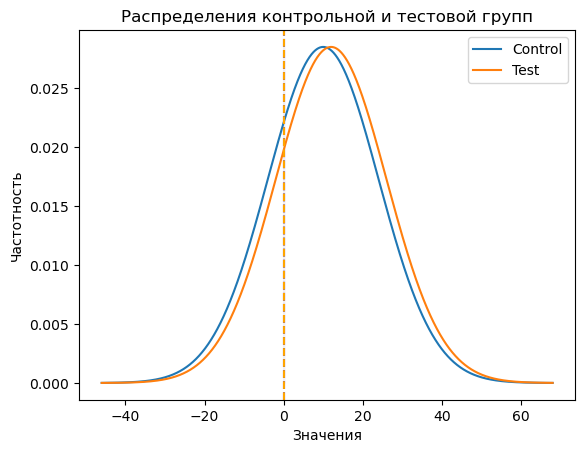

t-statistic: 1.43, p-value: 0.1547


In [33]:
# Задаем параметры нормальных распределений для control и test
mu_c, sigma_c = 10, 14
mu_t, sigma_t = 12, 14

# Генерируем случайные выборки для control и test
np.random.seed(0)
control = x_a
test = x_b

# Вычисляем основные статистики для control и test
mean_c, std_c = np.mean(control), np.std(control, ddof=1)
mean_t, std_t = np.mean(test), np.std(test, ddof=1)

# Вычисляем t-статистику и p-значение для различия между control и test
t, p = sps.ttest_ind_from_stats(mean_c, std_c, len(control), mean_t, std_t, len(test))

# Вычисляем границы доверительных интервалов для control и test
lower_c, upper_c = sps.norm.interval(0.95, loc=mean_c, scale=std_c)
lower_t, upper_t = sps.norm.interval(0.95, loc=mean_t, scale=std_t)

# Создаем объекты для отрисовки графика
x = np.linspace(mu_c - 4 * sigma_c, mu_t + 4 * sigma_t, 10000)
y_c = sps.norm.pdf(x, mu_c, sigma_c)
y_t = sps.norm.pdf(x, mu_t, sigma_t)

plt.plot(x, y_c, label='Control')
plt.axvline(mean_c, color='blue', linestyle='--')
plt.fill_betweenx(y_c, lower_c, upper_c, alpha=0.05, color='blue')

plt.plot(x, y_t, label='Test')
plt.axvline(mean_t, color='orange', linestyle='--')
plt.fill_betweenx(y_t, lower_t, upper_t, alpha=0.05, color='orange')

plt.title('Распределения контрольной и тестовой групп')
plt.xlabel('Значения')
plt.ylabel('Частотность')
plt.legend()
plt.show()

# Выводим полученные значения t-статистики и p-значения
print(f't-statistic: {t:.2f}, p-value: {p:.4f}')


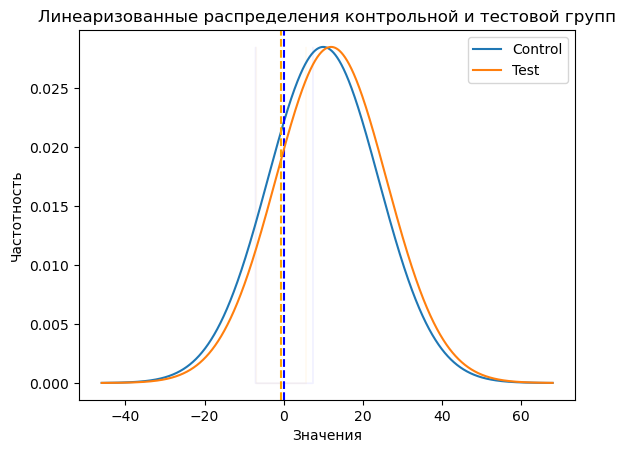

t-statistic: 1.49, p-value: 0.1372


In [34]:
# Задаем параметры нормальных распределений для control и test
mu_c, sigma_c = 10, 14
mu_t, sigma_t = 12, 14

# Генерируем случайные выборки для control и test
np.random.seed(0)
control = x_a_lin
test = x_b_lin

# Вычисляем основные статистики для control и test
mean_c, std_c = np.mean(control), np.std(control, ddof=1)
mean_t, std_t = np.mean(test), np.std(test, ddof=1)

# Вычисляем t-статистику и p-значение для различия между control и test
t, p = sps.ttest_ind_from_stats(mean_c, std_c, len(control), mean_t, std_t, len(test))

# Вычисляем границы доверительных интервалов для control и test
lower_c, upper_c = sps.norm.interval(0.95, loc=mean_c, scale=std_c)
lower_t, upper_t = sps.norm.interval(0.95, loc=mean_t, scale=std_t)

# Создаем объекты для отрисовки графика
x = np.linspace(mu_c - 4 * sigma_c, mu_t + 4 * sigma_t, 10000)
y_c = sps.norm.pdf(x, mu_c, sigma_c)
y_t = sps.norm.pdf(x, mu_t, sigma_t)

plt.plot(x, y_c, label='Control')
plt.axvline(mean_c, color='blue', linestyle='--')
plt.fill_betweenx(y_c, lower_c, upper_c, alpha=0.05, color='blue')

plt.plot(x, y_t, label='Test')
plt.axvline(mean_t, color='orange', linestyle='--')
plt.fill_betweenx(y_t, lower_t, upper_t, alpha=0.05, color='orange')

plt.title('Линеаризованные распределения контрольной и тестовой групп')
plt.xlabel('Значения')
plt.ylabel('Частотность')
plt.legend()
plt.show()

# Выводим полученные значения t-статистики и p-значения
print(f't-statistic: {t:.2f}, p-value: {p:.4f}')


3.Реализовать метод CUPED. Проверить для него корректность и мощность. Данные на этапе до A/B тесте необходимо сгенерировать один раз, далее синтетически генерировать только часть, связанную с проведением A/B-теста.

Проверка корреляции:  0.0004

Мощность теста: 5.6000000000000005


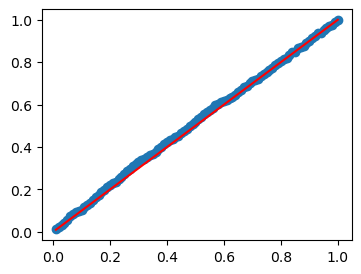


Мощность теста CUPED: 5.6000000000000005


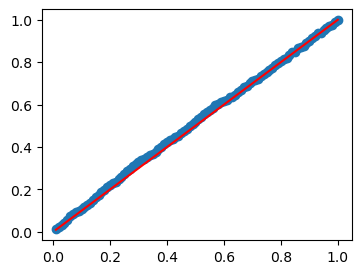

In [40]:
# Пподход cuped генерирует данные для двух групп (A и B) с помощью функций sps.norm.rvs и sps.expon.rvs. 
# Переменная size определяет размер выборки для каждой группы, который равен 1000. 

# Для каждого эксперимента проведем t-тест для оценки статистической значимости различия конверсии между контрольной и тестовой группами, как с использованием корректировки, так и без нее. 

# Также вычисляли линейную регрессию между количеством кликов и количеством просмотров для контрольной группы, чтобы получить корректировку для конверсии. 
# И оценка t-теста с использованием корректировки для оценки статистической значимости различия между группами.
n_exp = 1000
alpha =0.05
beta =0.2
size =  1000
p_value = []
pvalue_cuped = []
corr_vec = []
pre_exp = sps.norm.rvs(loc=100, scale = 140, size=size)
for i in range(n_exp):
    df_A = pd.DataFrame()
    df_A["user"] = [f"A_{i}" for i in range(size)]
    df_A["pre_exp"] = pre_exp
    df_A["payments"] = sps.expon.rvs(loc=100, scale = 100, size=size)

    df_B = pd.DataFrame()
    df_B["user"] = [f"B_{i}" for i in range(size)]
    df_B["pre_exp"] = pre_exp
    df_B["payments"] = sps.expon.rvs(loc=100, scale = 100, size=size)

    p_value.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)

    x_a = df_A["pre_exp"]
    x_b = df_B["pre_exp"]
    y_a = df_A["payments"]
    y_b = df_B["payments"]

    theta = np.cov(x_a, y_a)[0, 1] / np.std(x_a) ** 2
    corr_vec.append(theta)

    df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
    df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]

    pvalue_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)


print("Проверка корреляции: ", np.round(np.mean(corr_vec),4))

print("Мощность теста:", get_power(p_value))
qq_plot(p_value)

print("Мощность теста CUPED:", get_power(pvalue_cuped))
qq_plot(pvalue_cuped)

*по корректности все хорошо*

Проверка корреляции:  -0.0

Мощность теста: 100.0


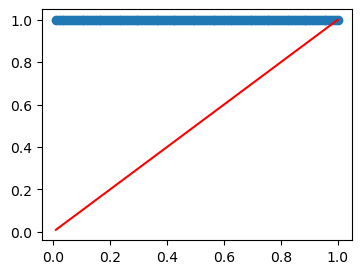


Мощность теста CUPED: 99.4


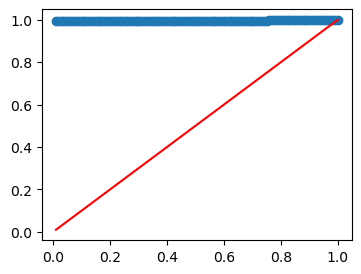

In [36]:
# синтетически находим связь между данными на предэксперименте и данными в эксперименте

n_exp = 1000
alpha =0.05
beta =0.2
size =  1000
p_value = []
pvalue_cuped = []
corr_vec = []
effect=0.05
pre_exp = sps.norm.rvs(loc=100, scale = 20, size=size)
for i in range(n_exp):
    df_A = pd.DataFrame()
    df_A["user"] = [f"A_{i}" for i in range(size)]
    df_A["pre_exp"] = pre_exp
    df_A["payments"] = sps.norm.rvs(loc=0.1, scale = 0.1, size=size) 

    df_B = pd.DataFrame()
    df_B["user"] = [f"B_{i}" for i in range(size)]
    df_B["pre_exp"] = pre_exp
    df_B["payments"] = sps.norm.rvs(loc=0.1 + effect, scale = 0.1, size=size)

    p_value.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)

    x_a = df_A["pre_exp"]
    x_b = df_B["pre_exp"]
    y_a = df_A["payments"]
    y_b = df_B["payments"]

    theta = np.cov(x_a, y_a)[0, 1] / np.std(x_a) ** 2
    corr_vec.append(theta)

    df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"] * df_A["pre_exp"]
    df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]

    pvalue_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)


print("Проверка корреляции: ", np.round(np.mean(corr_vec),4))

print("Мощность теста:", get_power(p_value))
qq_plot(p_value)
print("Мощность теста CUPED:", get_power(pvalue_cuped))
qq_plot(pvalue_cuped)

*создали зависимость выборок между данными перед экспериментом и во время и видим мозность на купиде выше.*

In [37]:
fig = go.Figure([go.Histogram(x=p_value, xbins={"start":0, "end":1, "size": 0.1})])
fig

In [38]:
fig = go.Figure([go.Histogram(x=pvalue_cuped, xbins={"start":0, "end":1, "size": 0.1})])
fig

*на последнем видим равномерное распределение, что говорит о корректности.*